# Seasonality Classification

### Amelia Bertozzi-Villa, Institute for Disease Modeling
September 2022

For a given covariate, this script runs k-means in  and plots the results. 

In [ ]:
install.packages('latticeExtra')
library(raster)
library(data.table)
library(stats)
library(gridExtra)
library(latticeExtra)
#library(hmisc)
library(FNN)
library(rgdal)
library(ggplot2)

Loading required package: sp


Attaching package: ‘data.table’


The following object is masked from ‘package:raster’:

    shift


Loading required package: lattice

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.5.0, released 2022/05/10
Path to GDAL shared files: /usr/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.0.1, June 15th, 2022, [PJ_VERSION: 901]
Path to PROJ shared files: /root/.local/share/proj:/usr/share/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.5-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.


Attaching package: ‘ggplot2’


The following 

Clear workspace

In [ ]:
rm(list=ls())

### USER SPECIFIED VARIABLES

In [ ]:
input_1 = 'unscaled'

In [ ]:
# one of: unscaled/rescaled/rescaled_and_bounded
#covariate_type <- "rescaled"
covariate_type <- input_1
cluster_counts <- c(3, 6, 8, 12)

### DATA VARIABLE INITIALIZATIONS

In [ ]:
base_dir <- file.path( "archetypes-data" )

main_dir <- file.path(base_dir, covariate_type)
palette <- c("#98B548", "#00A08A", "#8971B3", "#F2AD00", "#5392C2", "#D71B5A", "#902E57", "#F98400", "#B33539", "#367A40", "#063970", "#EACB44", "#8FBC94", "#75CCD0")

print("loading Africa shapefile")
africa_shp <- readOGR(file.path(base_dir, "shp", "Africa.shp"))
africa_dt <- data.table(fortify(africa_shp, region = "COUNTRY_ID"))

print("loading svd transformed variables")
rotation <- fread(file.path(main_dir, "svd_rotations.csv"))
vecnames_of_interest <- colnames(rotation)[colnames(rotation) %like% "X"]

# also load pre-svd covariates to get pixel ids
# this command loads an object named "covariate_ids" into the environment
load(file.path(main_dir, "covariate_ids.RData")) 

# find map from raster cells to rotation ids
temp_raster <- raster(file.path(main_dir, "mask.tif"))

[1] "loading Africa shapefile"
OGR data source with driver: ESRI Shapefile 
Source: "/datasets/archetypes-data/shp/Africa.shp", layer: "Africa"
with 63 features
It has 5 fields
[1] "loading svd transformed variables"


Create empty lists

In [ ]:
raster_list <- list()
raster_plotlist <- list()
random_trace_list <- list()
summary_stat_list <- list()
representative_site_list <- list()
full_plotlist <- list()

Define functions we'll use later...

In [ ]:
get_site_ids <- function( rotation )
{
  print("finding centroids for representative sites")
  # find cell IDs of centroids and map them to the appropriate locations
  site_ids <- rotation[get.knnx(rotation[, ..vecnames_of_interest], k_out$centers, k=1)$nn.index]
  names(site_ids) <- gsub("X", "singular_vector_", names(site_ids))
  site_id_lat_longs <- data.table(xyFromCell(cluster_raster, site_ids$id))
  setnames(site_id_lat_longs, c("x", "y"), c("longitude", "latitude"))
  site_ids <- cbind(site_ids, site_id_lat_longs)
  site_ids <- site_ids[order(-latitude)]
  site_ids[, ns_order:= as.integer(row.names(site_ids))]
  site_ids[, nclust:= nclust]
  return(site_ids)
}

In [ ]:
find_random_trace <- function( covariate_ids )
{
  print("finding random traces")
  random_grids <- sample(unique(covariate_ids$id), 1000)
  random_trace <- covariate_ids[id %in% random_grids]
  random_trace[, nclust:= nclust]
  return( random_trace )
}

In [ ]:
make_cluster_plot <- function( cluster_raster, these_colors )
{
	print("Plot 1: Map")
	cluster_dt <- data.table(rasterToPoints(cluster_raster))
	names(cluster_dt) <- c("long", "lat", "value")
	cluster_dt[, value:= as.factor(value)]

	cluster_plot <- ggplot() +
		geom_raster(data = cluster_dt, aes(fill = value, y = lat, x = long)) +
		geom_path(data = africa_dt, aes(x = long, y = lat, group = group), color = "black", size = 0.3) + 
		scale_fill_manual(values=these_colors) +
		coord_equal(xlim = c(-18, 52), ylim = c(-35, 38)) +
		labs(x = NULL,
		     y = NULL, 
		     title = NULL
		     ) +
theme_classic(base_size = 12) +
theme(axis.line = element_blank(), 
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      plot.margin = unit(c(0, 0, 0, 0), "in"),
      legend.position = "none",
      plot.title = element_text(hjust = 0.5))

# add representative sites 
site_id_spoints <- xyFromCell(cluster_raster, site_ids$id, spatial=T) # convert sites to lat-longs spatialpoints
cluster_plot <- cluster_plot + 
	geom_point(data=data.table(site_id_spoints@coords), aes(x=x, y=y), color="black", shape=3, size=3) +
	labs(title=paste(nclust, "Clusters"))

  return(cluster_plot)
}

In [ ]:
create_new_raster <- function( rotation )
{
  print("creating new raster")
  cluster_raster <- rep(NA, ncell(temp_raster))
  cluster_raster[rotation$id] <- rotation$cluster
  cluster_raster <- matrix(cluster_raster, nrow=nrow(temp_raster), byrow=T)
  cluster_raster <- raster(cluster_raster, template=temp_raster)
  return( cluster_raster )
}

In [ ]:
get_lines <- function( summary_stats, these_colors )
{
  print("Plot 2: Time Series")
  time_series <- summary_stats[variable_name=="month"]
  time_series  <- merge(time_series, site_ids[, list(cluster, ns_order)], by="cluster", all.x=T)
  time_series[, cluster:=as.factor(cluster)]
    lines <- lapply(unique(time_series$cov), function(cov_value){

    subplot_title <- ifelse(cov_value %like% "temp", " Air Temperature", "Precipitation")

    data <- time_series[cov==cov_value]
    selected_sites <- covariate_ids[id %in% site_ids$id & cov==cov_value & variable_name=="month"]
    selected_sites <- merge(selected_sites, site_ids[, list(id, cluster, ns_order)], by="id", all=T)
    selected_sites[, cluster:=as.factor(cluster)]

    if (max(data$perc_95)>1){
      y_breaks <- seq(0, round(max(data$perc_95)), length.out=3)
      y_labs <- c("0", as.character(round(max(data$perc_95)/2)), as.character(round(max(data$perc_95))))
      y_lims <- c(0, round(max(data$perc_95)))
    }else{
      y_breaks <- c(0,0.5,1)
      y_labs <- c("0", "0.5", "1")
      y_lims <- c(0,1)
    }

    line_plot <- ggplot(data, aes(x=as.integer(variable_val), y=median, color=cluster, fill=cluster)) +
      facet_grid(ns_order~.) +
      geom_ribbon(aes(ymin=perc_25, ymax=perc_75), alpha=0.5, color=NA) +
      geom_line(size=0.5) +
      geom_line(aes(y=perc_05), size=0.25, linetype=2) +
      geom_line(aes(y=perc_95), size=0.25, linetype=2) +
      geom_line(data=selected_sites, aes(y=cov_val), color="black", size=0.5) +
      scale_color_manual(values = these_colors) +
      scale_fill_manual(values = these_colors) + 
      scale_x_continuous(breaks=seq(2,12,2), labels=c("F","A","J","A","O","D"), minor_breaks=seq(1,12,2)) +
      scale_y_continuous(breaks=y_breaks, labels=y_labs, limits=y_lims) +
      theme_minimal(base_size=8) +
      theme(legend.position="none",
            plot.title = element_text(hjust = 0.5),
            strip.background = element_blank(),
            strip.text.y = element_blank()) +
      labs(title=subplot_title,
           x="",
           y="")

    return(line_plot)

  })
  return(lines)
}

In [ ]:
get_colors <- function( nclust )
{
  print("preparing plots")
  # find appropriate colors-- revert to a ggplot standard if nclust is too long for the custom palette
  if (nclust<=length(palette)){
    these_colors <- palette[1:nclust]
  }else{
    gg_color_hue <- function(n) {
      hues = seq(15, 375, length = n + 1)
      hcl(h = hues, l = 65, c = 100)[1:n]
    }
    these_colors <- gg_color_hue(nclust)
  }
  return( these_colors )
}

In [ ]:
get_vector_mix <- function( covariate_ids, site_ids )
{
  print("Plot 3: Vector Mix")
  vector_props <- covariate_ids[variable_name=="species" & id %in% site_ids$id]
  vector_props <- merge(vector_props, site_ids[, list(id, cluster, ns_order)], by="id", all=T)
  vector_props[, cluster:=as.factor(cluster)]

  vector_props[, fraction:=cov_val]
  vector_props[, ymax:=cumsum(fraction), by="cluster"] # Compute the cumulative percentages
  vector_props[, ymin:=ymax-fraction] 
  vector_props[, variable_val:= factor(variable_val, levels=c("arabiensis", "coluzzii_gambiae", "funestus_subgroup"), labels=c("ara", "gam", "fun"))]

  vector_mix <- ggplot(vector_props, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3)) +
    geom_rect(aes(fill=variable_val)) + 
    theme_void(base_size=8) +
    theme(legend.position="bottom",
          legend.key.size = unit(0.25, "cm"),
          strip.background = element_blank(),
          plot.title = element_text(hjust = 0.5),
          strip.text = element_blank()) +
    scale_fill_manual(values=c("#ffd92f", "#a6d854", "#8da0cb"), name="")+ 
    facet_grid(ns_order ~ .) + 
    coord_polar(theta = "y") +
    xlim(c(2,4)) +
    labs(title="Species",
         x="Cluster",
         y="")
  return(vector_mix)
}

### Now for main k-means loop...

In [ ]:
# k-means
for (nclust in cluster_counts)
{
  # ensure replicability of results
  set.seed(206)
  print(paste("finding clusters for k of", nclust))
  k_out <- kmeans(rotation[, ..vecnames_of_interest], centers=nclust, algorithm = "MacQueen", iter.max=100)
  rotation[, cluster:= k_out$cluster]
  covariate_ids <- merge(covariate_ids, rotation[, list(id, cluster)], by="id", all=T)

  cluster_raster = create_new_raster( rotation )
  raster_list <- append(raster_list, cluster_raster)

  random_trace = find_random_trace( covariate_ids )
  random_trace_list <- append(random_trace_list, list(random_trace))

  print("finding summary stats")
  summary_stats <- covariate_ids[,list(mean=mean(cov_val),
                                 perc_25=quantile(cov_val, c(0.25)),
                                 perc_75=quantile(cov_val, c(0.75)),
                                 perc_05=quantile(cov_val, c(0.025)),
                                 perc_95=quantile(cov_val, c(0.975)),
                                 median=median(cov_val)), by=list(cluster, variable_name, variable_val, cov)]
  summary_stats[, nclust:=nclust]
  summary_stat_list <- append(summary_stat_list, list(summary_stats))

  # delete so covariate_ids can be used again for the next round of k-means
  covariate_ids[, cluster:=NULL]

  site_ids = get_site_ids( rotation )
  representative_site_list <- append(representative_site_list, list(site_ids))

  ### Plotting
  these_colors = get_colors( nclust )
  plotlist <- list() # this list contains all the subplot elements that later get combined

  ## 1. make cluster map with representative sites overlaid
  cluster_plot = make_cluster_plot( cluster_raster, these_colors )
  plotlist[[1]] <- cluster_plot
  raster_plotlist <- append(raster_plotlist, list(cluster_plot))

  ## 2. time series of rainfall and temperature
  # separate set of subplots for each time series covariate
  lines <- get_lines(summary_stats, these_colors)
  plotlist <- append(plotlist, lines)

  ## 3. Plot Vector mix for representative sites
  vector_mix = get_vector_mix( covariate_ids, site_ids )
  vector_idx <- length(plotlist) +1 
  plotlist[[vector_idx]] <- vector_mix

  full_plotlist <- append(full_plotlist, list(plotlist))
}

[1] "finding clusters for k of 3"
[1] "creating new raster"
[1] "finding random traces"
[1] "finding summary stats"
[1] "finding centroids for representative sites"
[1] "preparing plots"
[1] "Plot 1: Map"
[1] "Plot 2: Time Series"
[1] "Plot 3: Vector Mix"
[1] "finding clusters for k of 6"
[1] "creating new raster"
[1] "finding random traces"
[1] "finding summary stats"
[1] "finding centroids for representative sites"
[1] "preparing plots"
[1] "Plot 1: Map"
[1] "Plot 2: Time Series"
[1] "Plot 3: Vector Mix"
[1] "finding clusters for k of 8"
[1] "creating new raster"
[1] "finding random traces"
[1] "finding summary stats"
[1] "finding centroids for representative sites"
[1] "preparing plots"
[1] "Plot 1: Map"
[1] "Plot 2: Time Series"
[1] "Plot 3: Vector Mix"
[1] "finding clusters for k of 12"
[1] "creating new raster"
[1] "finding random traces"
[1] "finding summary stats"
[1] "finding centroids for representative sites"
[1] "preparing plots"
[1] "Plot 1: Map"
[1] "Plot 2: Time Series"


In [ ]:
# clean and manage outputs
names(raster_list) <- paste0("nclust_", cluster_counts)
random_traces_all <- rbindlist(random_trace_list)
summary_stats_all <- rbindlist(summary_stat_list)
representative_sites_all <- rbindlist(representative_site_list)

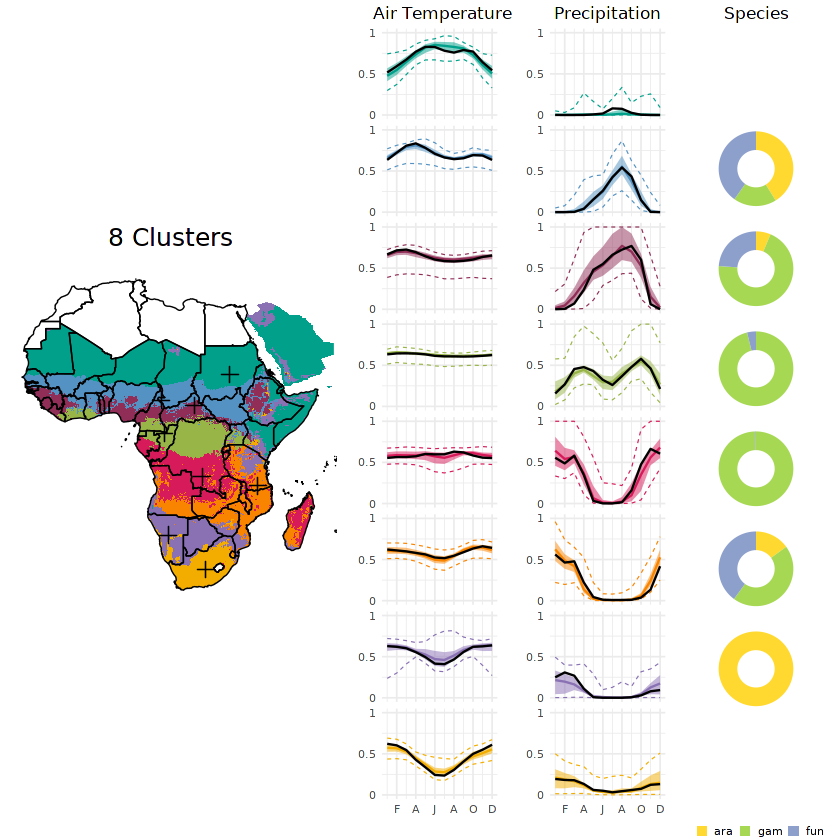

In [ ]:
# If desired, plot individual large plots
nclust_to_plot <- 8 ## USER-SPECIFIED 
plot_id <- which(cluster_counts==nclust_to_plot)
layout <- matrix(c(1, 1:(length(lines)+1), vector_idx), nrow=1)
grid.arrange(grobs=full_plotlist[[plot_id]], layout_matrix=layout)

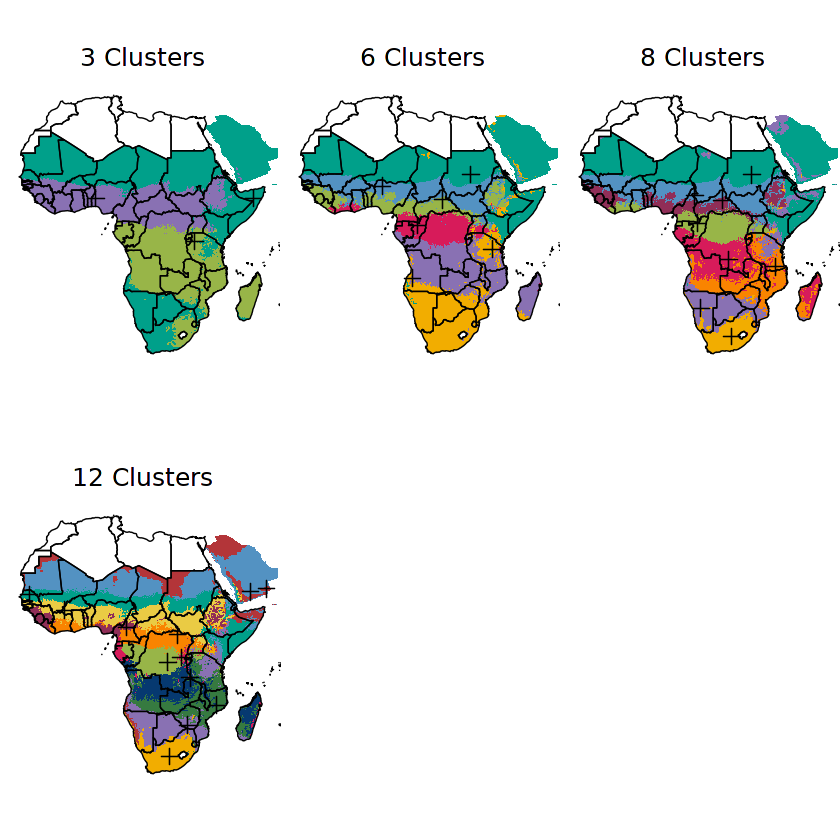

In [ ]:
# plot all cluster maps
do.call("grid.arrange", c(raster_plotlist, ncol=3))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=65d2dc5e-e433-4869-b897-5fd659a93879' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>